In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib nbagg
#%matplotlib inline
import pandas as pd
import os

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


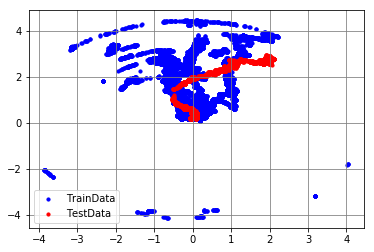

In [2]:
#----------TRAIN-------------#
target_path = '../data/LOG_G/stable/'
contents = os.listdir(target_path)
data = pd.DataFrame()
num = 0
for c in range(len(contents)):
    #print(target_path+contents[c])
    n_data = pd.read_csv(target_path+contents[c],header=None)
    data = pd.concat([data,n_data])
    
#----------TEST-------------#
test_path = '../data/test/test_zenhoukou.csv'
contents = os.listdir(target_path)
test_data = pd.read_csv(test_path,header=None)

plt.hold(True)
plt.grid(color='gray')
plt.scatter(data[1],data[0], s=10, c='blue',label='TrainData')
plt.grid(color='gray')
plt.scatter(test_data[1],test_data[0], s=10, c='red',label='TestData')
plt.legend()


In [3]:
# モデルの定義
IN_size = 6
TAR_size = 4
INPUT = tf.placeholder(shape=[None, IN_size], dtype=tf.float32)
TARGET = tf.placeholder(shape=[None, TAR_size], dtype=tf.float32)

hidden_size = [20 ,10]
batch_size = 100
iter_size = 100000

#　隠れ層の作成 （last layerに直結）
weights = []
biases = []
layers = []
tmp_size = IN_size
last_layer = INPUT
for hsize in hidden_size:
    weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, hsize], stddev=10.0)))
    biases.append(tf.Variable(tf.random_normal(shape=[hsize], stddev=10.0)))
    layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))) # 活性化関数
    tmp_size = hsize
    last_layer = layers[-1]
    print(layers[-1])
#　出力層
weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, TAR_size], stddev=10.0)))
biases.append(tf.Variable(tf.random_normal(shape=[TAR_size], stddev=10.0)))
layers.append(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))
final_output = layers[-1]

loss = tf.losses.mean_squared_error(TARGET,final_output)

Tensor("Relu:0", shape=(?, 20), dtype=float32)
Tensor("Relu_1:0", shape=(?, 10), dtype=float32)


In [4]:
# 重みのrestore
saver = tf.train.Saver()
predicts_sess = tf.Session()
ckpt = tf.train.get_checkpoint_state('./')
if ckpt == None:
    print('!!!!!!!WEIGHTS NOT FOUND!!!!!!')

saver.restore(predicts_sess, './model.ckpt')

INFO:tensorflow:Restoring parameters from ./model.ckpt


In [5]:
test_data.columns = ['l_bx','l_by','l_pole0x','l_pole0y','l_pole1x','l_pole1y','g_bx','g_by','g_pole0x','g_pole0y','g_pole1x','g_pole1y','g_px','g_py','g_pth','ljx','ljy','rjx','rjy']
#test_data = test_data[test_data.bx!=-1]
#s_INPUT = np.array(test_data.iloc[:,0:2])
#s_ANS = np.array(test_data.iloc[:,2:4])

s_INPUT = np.array(test_data.iloc[:,0:6])
s_ANS = np.array(test_data.iloc[:,14:18])

#pred = np.empty((0,3),np.float32)
res = np.empty((0,4),np.float32)
for i in range(len(s_INPUT)):
    s_input = np.array([s_INPUT[i]])
    s_ans = np.array([s_ANS[i]])

    p = predicts_sess.run(final_output, feed_dict={INPUT: s_input})
    test_loss = predicts_sess.run(loss, feed_dict={INPUT: s_input,TARGET:s_ans})
    
    res = np.append(res, p, axis=0)

    #col = np.c_[test_loss, s_input]
    #pred = np.append(pred, col, axis=0)
print(res.shape)    
#p_pred = pd.DataFrame(pred,columns=list('pxy'))
#sorted_data = p_pred.sort_values(by='p',ascending=False) #p列において値の大きい順にソート
#print(len(pred))

(2204, 4)


In [6]:
'''
plt.hold(True)
plt.scatter(data[1]/100,data[0]/100, s=10, c='palegreen',label='TrainData')

thresh = 1

#----------TEST-------------#
for t in range(len(pred)):
    if pred[t][0] < thresh: #まあほぼ正解
        plt.scatter(pred[t][2],pred[t][1], s=10, c='lightcoral')
    else: #失敗
        plt.scatter(pred[t][2],pred[t][1], s=10, c='c')
'''

"\nplt.hold(True)\nplt.scatter(data[1]/100,data[0]/100, s=10, c='palegreen',label='TrainData')\n\nthresh = 1\n\n#----------TEST-------------#\nfor t in range(len(pred)):\n    if pred[t][0] < thresh: #まあほぼ正解\n        plt.scatter(pred[t][2],pred[t][1], s=10, c='lightcoral')\n    else: #失敗\n        plt.scatter(pred[t][2],pred[t][1], s=10, c='c')\n"

(2204,)
(2204,)


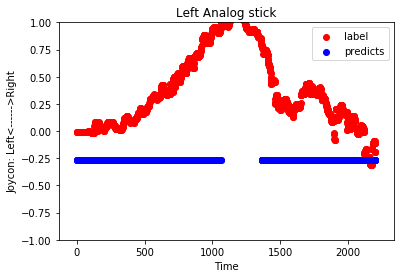

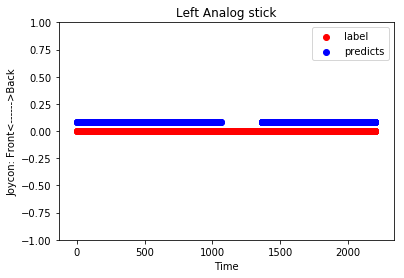

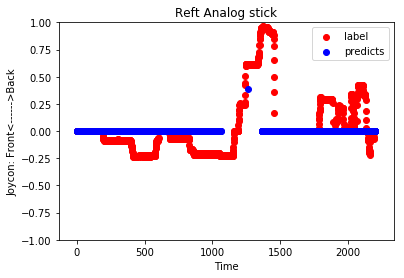

In [9]:
t = np.empty(len(s_INPUT))
l = np.array([list(range(len(s_INPUT)))])
t[:]=l

print(t.shape)
print(s_ANS[:,1].shape)

plt.figure(1)
plt.scatter(t,s_ANS[:,0],color='r', label='label') #ラベルjx
plt.scatter(t,res[:,0],color='b', label='predicts')    #予測
plt.ylim(-1,1)
plt.xlabel("Time")
plt.ylabel("Joycon: Left<------>Right")
plt.title('Left Analog stick')
plt.savefig("test_rightleft.png")
plt.legend()

plt.figure(2)
plt.scatter(t,s_ANS[:,1],color='r', label='label') #ラベルjx
plt.scatter(t,res[:,1],color='b', label='predicts')    #予測
plt.ylim(-1,1)
plt.xlabel("Time")
plt.ylabel("Joycon: Front<------>Back")
plt.title('Left Analog stick')
plt.savefig("test_frontback.png")
plt.legend()

plt.figure(3)
plt.title('Reft Analog stick')
plt.scatter(t,s_ANS[:,3],color='r', label='label') #ラベルjx
plt.scatter(t,res[:,3],color='b', label='predicts')    #予測
plt.ylim(-1,1)
plt.xlabel("Time")
plt.ylabel("Joycon: Front<------>Back")
plt.savefig("test_kakudai.png")


plt.legend()
